# ME234b Prelab 3(c) Development

- Generate waypoint sequence with A-Star
- Follow this trajectory with MPC
    - Simulate $N_h$ timesteps $w$ times with MPC, where the first simulation is done with proportional control as a "warm start"
    - Take the first step with MPC
    - Repeat
    
### MPC Optimization problem
From notes
$$
\min_{\{u_i\}_{i=1}^{N_h},\ \{x_i\}_{i=1}^{N_h}}
(x_{N_h}-x_{ref})^TQ(x_{N_h}-x_{ref})
+ \sum_{i=1}^{N_h}u_i^TRu_i + [\mathrm{OMITTED}]\\
\mathrm{subject\ to}\\
x_0=x_{0,\mathrm{given}}\\
x_{k+1} = A(x_k^{w-1}, u_k^{w-1})x_k 
    + B(x_k^{w-1},u_k^{w-1})u_k + C(x_k^{w-1},u_k^{w-1})
$$

OSQP:
$$
\begin{split}\begin{array}{ll}
  \mbox{minimize}   & (x_N-x_r)^T Q_N (x_N-x_r) + \sum_{k=0}^{N-1} (x_k-x_r)^T Q (x_k-x_r) + u_k^T R u_k \\
  \mbox{subject to} & x_{k+1} = A x_k + B u_k \\
                    & x_{\rm min} \le x_k  \le x_{\rm max} \\
                    & u_{\rm min} \le u_k  \le u_{\rm max} \\
                    & x_0 = \bar{x}
\end{array}\end{split}
$$

# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import osqp
import scipy as sp
from scipy import sparse
import cvxpy as cvx

import getUProportional as gu

## Auxiliary functions

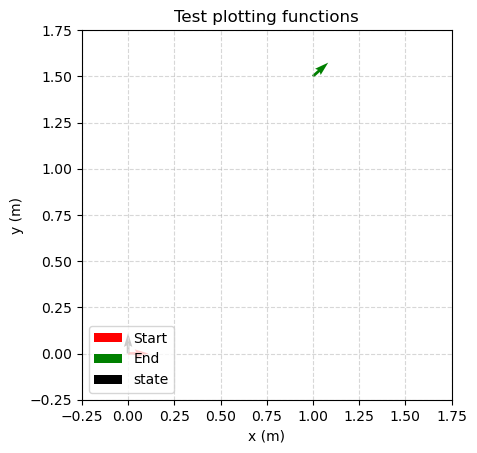

In [2]:
def initPlotSpace():
    plt.xlim([-1/4, 1.75])
    plt.ylim([-1/4, 1.75])
    plt.grid(alpha=0.5, ls="--")
    plt.gca().set_aspect('equal')
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")

def plotState(vecx, color='black', label="", alpha = 1):
    xy_start = vecx[0], vecx[1]
    xy_end = [vecx[0] + np.cos(vecx[2]),
        vecx[1] + np.sin(vecx[2])]
    plt.quiver(*xy_start, *xy_end, color=color, label=label, alpha=alpha)

plt.figure()
vecx = np.array([0, 0, np.pi/2])

vecx_0 = np.array([0,0,0])
vecx_f = np.array([1, 1.5, np.pi/12])

initPlotSpace()
plotState(vecx_0, color="red", label="Start")
plotState(vecx_f, color="green", label="End")
plotState(vecx, label="state")
plt.legend(loc="lower left")
plt.title("Test plotting functions")

def plotResult(x_cvx, w, vecx_0=vecx_0, vecx_f=vecx_f):
    fig = plt.figure()
    initPlotSpace()
    plotState(vecx_0, color="red", label="Start")
    n_k = x_cvx.shape[1]
    for k, vecx_k in enumerate(x_cvx.T):
        plotState(vecx_k, color=mpl.cm.viridis(k/n_k))
    plotState(vecx_f, color="green", label="End")
    plt.legend(loc="lower right")
    plt.title("Trajectory for $w=%d$ with $%d$ steps"%(w, n_k))
    
    return fig

## Warm start 

In [3]:
def getNextState_pasthw(vecx_0, vecu, dt):
    assert vecx_0.shape == (3,)
    assert vecu.shape == (2,)
    
    
    x_0, y_0, theta_0 = vecx_0
    V, omega = vecu
    
    vecx_1 = np.array([
        x_0 + V*np.cos(theta_0)*dt,
        y_0 + V*np.sin(theta_0)*dt,
        theta_0 + omega*dt
    ])
    
    return vecx_1

def getNextState(vecx_0, vecu, dt):
    assert vecx_0.shape == (3,)
    assert vecu.shape == (2,)
    
    
    x_0, y_0, theta_0 = vecx_0
    V, omega = vecu
    
    vecx_1 = np.array([
        x_0 - V*np.sin(theta_0)*dt + V*np.cos(theta_0)*dt,
        y_0 + V*np.cos(theta_0)*dt + V*np.sin(theta_0)*dt,
        theta_0 + omega*dt
    ])
    
    return vecx_1

def getWarmStart(vecx_0, vecx_f, vecu_0, N_h,
             K_h=-0.9, K_p=-0.9):
    THETA_TOL_DEG = 10 # degrees
    V_MAX = 0.5 # m/s
    OMEGA_MAX = np.pi/3 # rad/s

    xy_tol = 0.1 # meters
    theta_tol = THETA_TOL_DEG*np.pi/180
    t = 0
    dt = 0.1 # seconds, corresp to 10 Hz
    t_max = 100
    k = 0
    k_max = N_h+1

    vecx = vecx_0
    xy_err_l2s = np.zeros((k_max,))
    theta_errs = np.zeros((k_max,))
    vecxs = np.zeros((3, k_max))
    vecus = np.zeros((2, k_max))
    ts = np.zeros((k_max,))

    while (k < k_max):
        xy_err_l2 = np.linalg.norm(vecx_f[:-1] - vecx[:-1])
        theta_err = vecx_f[-1] - vecx[-1]
        theta_err_abs = np.abs(theta_err)

        vecu = gu.getUProportional(vecx_0 = vecx, vecx_f = vecx_f,
                                   xy_tol=xy_tol, theta_tol=theta_tol,
                                  xy_err_l2 = xy_err_l2,
                                  theta_err_abs=theta_err_abs,
                                  K_h=K_h,K_p=K_p)
        vecu[0] = np.sign(vecu[0])*min(abs(vecu[0]), V_MAX)
        vecu[1] = np.sign(vecu[1])*min(abs(vecu[1]), OMEGA_MAX)
        assert abs(vecu[0]) <= V_MAX, "%f > %f"%(abs(vecu[0]), V_MAX)
        
        vecx = getNextState(vecx_0=vecx, vecu=vecu, dt=dt)

        theta_errs[k] = theta_err
        xy_err_l2s[k] = xy_err_l2
        vecxs[:, k] = vecx
        vecus[:, k] = vecu
        ts[k] = t

        k += 1
        t += dt


        #if np.isclose(vecu, np.zeros((2,))).all():
        #    break

    return vecxs, vecus

# Kinematic model

$$
\vec x = \begin{bmatrix}
    x\\
    y\\
    \theta
\end{bmatrix},\ \ 
\vec u = \begin{bmatrix}
    V\\
    \omega
\end{bmatrix}\\
$$

$$
A_d(\vec x,\vec u) = \begin{bmatrix}
1 & 0 & -V\sin(\theta)dt\\
0 & 1 & V\cos(\theta)dt\\
0 & 0 & 1\\
\end{bmatrix},\ \ 
B_d(\vec x,\vec u) = \begin{bmatrix}
    \cos(\theta)dt & 0\\
    \sin(\theta)dt & 0\\
    0 & \omega dt\\
\end{bmatrix},\ \ \\
$$

$$
\vec x_{k+1} =
\begin{bmatrix}
1 & 0 & -V_k\sin(\theta_k)dt\\
0 & 1 & V_k\cos(\theta_k)dt\\
0 & 0 & 1\\
\end{bmatrix}
\begin{bmatrix}
    x_k\\
    y_k\\
    \theta_k
\end{bmatrix} + 
\begin{bmatrix}
    \cos(\theta_k)dt & 0\\
    \sin(\theta_k)dt & 0\\
    0 & dt\\
\end{bmatrix}\begin{bmatrix}
    V_k\\
    \omega_k
\end{bmatrix}
$$

In [4]:
# Dimensionality
n_x = 3
n_u = 2
dt = 0.1

# Kinematics
def getA_d(vecx, vecu, dt=dt):
    assert vecx.shape == (n_x,), str(vecx)
    assert vecu.shape == (n_u,), str(vecu)
    
    V = vecu[0]
    theta = vecx[2]
    A_d = np.array([[1, 0, -V*np.sin(theta)*dt],
                    [0, 1,  V*np.cos(theta)*dt],
                    [0, 0,                   1]])
    return A_d
A_d = getA_d

def getB_d(vecx, vecu, dt=dt):
    assert len(vecu)==n_u
    theta = vecx[2]
    B_d = np.array([[np.cos(theta)*dt,  0],
                    [np.sin(theta)*dt,  0],
                    [0               , dt]])
    return B_d
B_d = getB_d

# Optimization problem
Use CVXPY OSQP example: https://osqp.org/docs/examples/mpc.html
Modified to recalculate $A_d$ and $B_d$ to be functions of current state instead of time-invariant

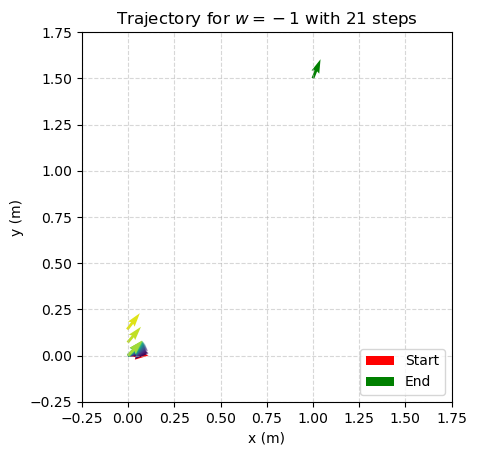

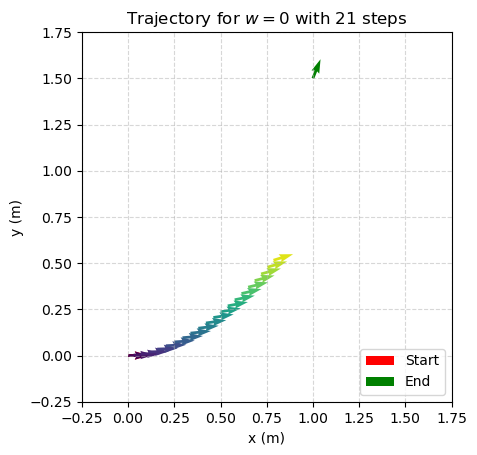

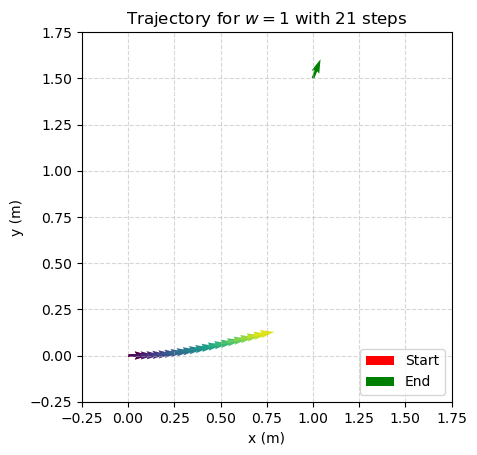

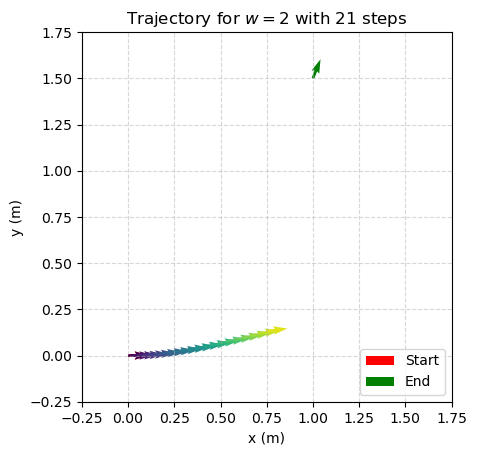

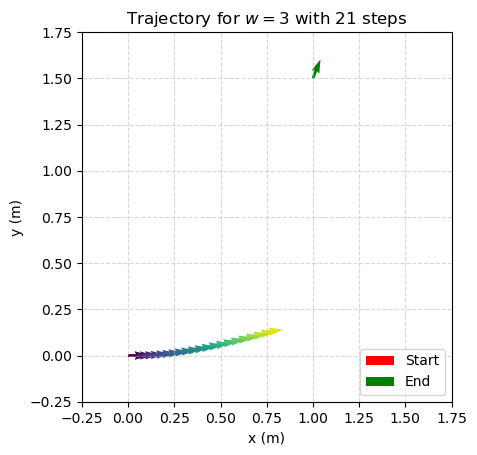

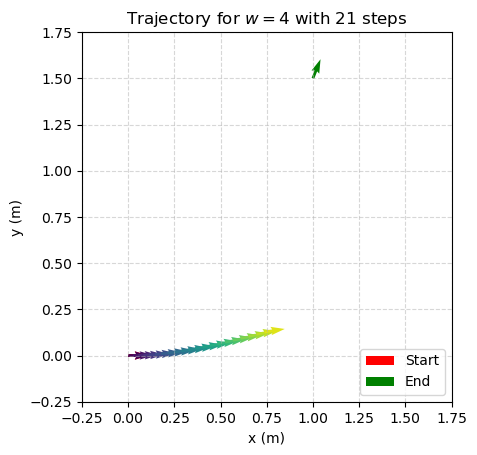

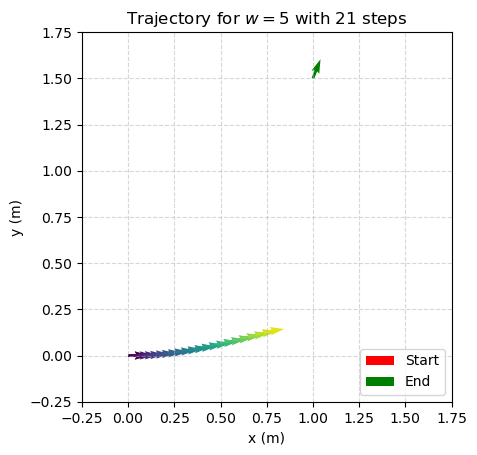

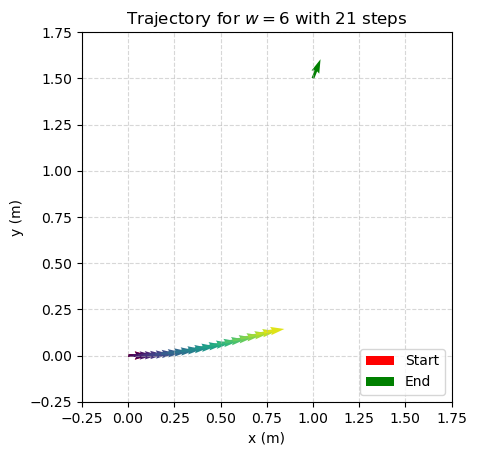

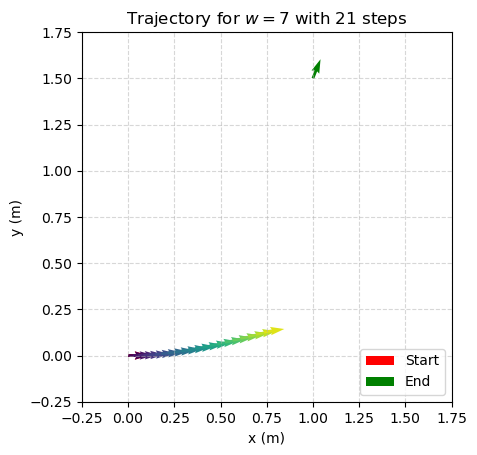

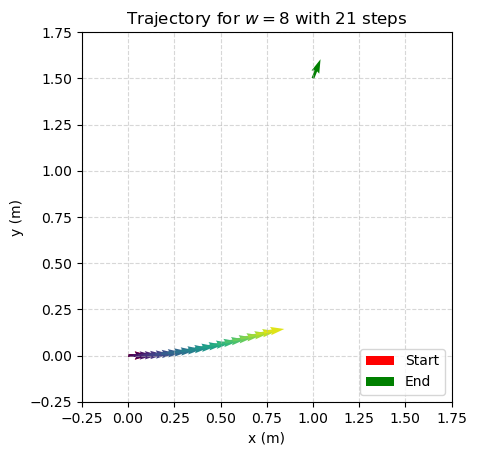

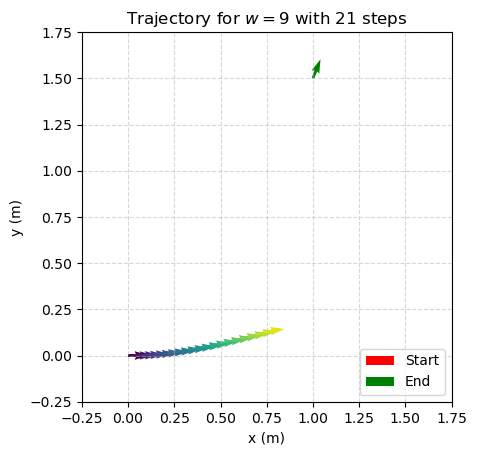

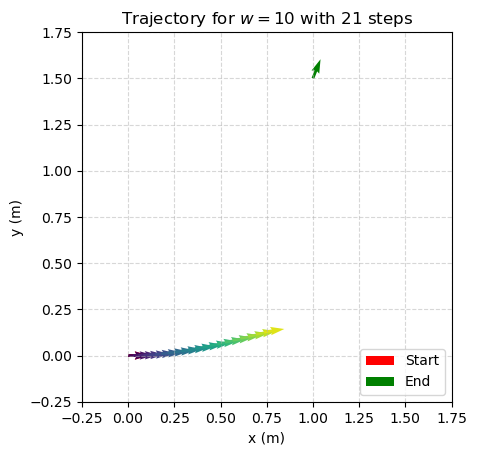

In [9]:
#### Parameters
# Costs 
# Note costs work best when omega is expensive and 
# theta deviation is cheap
Q, R = np.eye(n_x), 0.1*np.eye(n_u)
Q[-1,-1] = 0.1
R[-1,-1] = 1

# Target
vecx_0 = np.array([0,0,0])
vecx_ref = np.array([1, 1.5, np.pi/2])
vecu_0 = np.array([0,0])

# Prediction horizon
N_h = 20
N_mpc = 11 # Even numbers work better (?)

# Constraints
V_max, omega_max = 0.5, np.pi/3 # m/s, rad/s

#### Optimization  setup
def getProblem(x_prev_np, u_prev_np,
            vecx_0=vecx_0, vecx_ref=vecx_ref, vecu_0=vecu_0,
            Q=Q,R=R,
            V_max=V_max, omega_max=omega_max):
    vecu_max = np.array([V_max, omega_max])
    vecu_min = -vecu_max
    vecx_max = np.array([np.inf, np.inf, np.inf])
    vecx_min = -vecx_max
    
    u_cvx = cvx.Variable((n_u, N_h))
    x_cvx = cvx.Variable((n_x, N_h+1))
    x_init_cvx = cvx.Parameter(n_x, name="x_init")
    x_init_cvx.value = vecx_0
    objective = 0
    constraints = [x_cvx[:,0]==x_init_cvx]
    for k in range(N_h):
        # Seems to break if we run MPC with state cost per state instead of
        # just at the end
        #objective += cvx.quad_form(x_cvx[:,k] - vecx_ref, Q) \
        #    + cvx.quad_form(u_cvx[:,k], R)
        objective += cvx.quad_form(u_cvx[:,k], R)
        A_d = getA_d(vecx=x_prev_np[:,k],vecu=u_prev_np[:,k])
        B_d = getB_d(vecx=x_prev_np[:,k],vecu=u_prev_np[:,k])
        constraints += [x_cvx[:,k+1] == A_d@x_cvx[:,k]+B_d@u_cvx[:,k]]
        constraints += [vecx_min <= x_cvx[:,k], x_cvx[:,k] <= vecx_max]
        constraints += [vecu_min <= u_cvx[:,k], u_cvx[:,k] <= vecu_max]
    objective += cvx.quad_form(x_cvx[:,N_h] - vecx_ref, Q)
    prob = cvx.Problem(cvx.Minimize(objective), constraints)
    return prob, x_init_cvx, x_cvx, u_cvx

# Warm start
x_warmstart, u_warmstart = getWarmStart(vecx_0=vecx_0,
                                        vecx_f=vecx_ref,
                                        vecu_0=vecu_0, N_h=N_h)

# Run optimization
prob, x_init_cvx, x_cvx, u_cvx = getProblem(x_prev_np=x_warmstart,
                              u_prev_np=u_warmstart)
vecx = vecx_0
vecu = vecu_0

plotResult(x_warmstart, vecx_f=vecx_ref, w=-1)

for w in range(N_mpc):
    
    prob.solve(solver=cvx.OSQP, warm_start=False)
    
    if x_cvx.value is not None: #and N_mpc < 10:
        plotResult(x_cvx.value, vecx_f=vecx_ref, w=w)
        plt.draw()
    
    if w < N_mpc-1:
        prob, x_init_cvx, x_cvx, u_cvx = getProblem(x_prev_np=x_cvx.value,
                                  u_prev_np=u_cvx.value)    
    #vecu = u_cvx[:,0].value
    #vecx = getA_d(vecx,vecu)@vecx + getB_d(vecx,vecu)@vecu
    #vecxs.append(vecx)



# TO DO: Step forward using first MPC item

***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***